In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
SEED = 42

In [4]:
df = pd.read_csv("dataset/diamonds.csv")
df.head(8)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [6]:
df.isnull().sum().any()

False

In [7]:
df = df.drop(["Unnamed: 0"], axis = 1)
df = df.drop_duplicates().reset_index(drop = True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53794.0,0.797780,0.473390,0.2,0.40,0.70,1.04,5.01
depth,53794.0,61.748080,1.429909,43.0,61.00,61.80,62.50,79.00
table,53794.0,57.458109,2.233679,43.0,56.00,57.00,59.00,95.00
price,53794.0,3933.065082,3988.114460,326.0,951.00,2401.00,5326.75,18823.00
x,53794.0,5.731214,1.120695,0.0,4.71,5.70,6.54,10.74
y,53794.0,5.734653,1.141209,0.0,4.72,5.71,6.54,58.90
z,53794.0,3.538714,0.705037,0.0,2.91,3.53,4.03,31.80


In [9]:
format_dict = {"carat" : "{:.2f}", "depth" : "{:.1f}", "table" : "{:.1f}", "x" : "{:.2f}", "y" : "{:.2f}", "z" : "{:.2f}"}
df_zero = df.loc[(df["x"] == 0) | (df["y"] == 0) | (df["z"] == 0)]
df_zero.style.apply(lambda x: ["background: yellow" if n == 0 else "" for n in x], axis = 1).format(format_dict)

,carat,cut,color,clarity,depth,table,price,x,y,z
2201,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.00
2308,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.00
4778,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.00
5457,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.00
10145,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.00
11156,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.00
11935,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.00
13570,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.00
15914,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.00
24338,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.00


In [10]:
df.loc[df["x"] == 0, "x"] = np.nan 
df.loc[df["y"] == 0, "y"] = np.nan 
df.loc[df["z"] == 0, "z"] = np.nan 
df[["x", "y", "z"]].isnull().sum()

x     7
y     6
z    19
dtype: int64

In [11]:
def get_corr(col):
    return df.corr().unstack()[col].sort_values(ascending = False)    

In [12]:
print("x correlations\n\n{0}\n\n{3}\n\ny correlations\n\n{1}\n\n{3}\n\nz correlations\n\n{2}".format(get_corr("x"), get_corr("y"), get_corr("z"), 25*"-"))

x correlations

x        1.000000
carat    0.977842
z        0.975382
y        0.974837
price    0.887133
table    0.195484
depth   -0.025304
dtype: float64

-------------------------

y correlations

y        1.000000
x        0.974837
z        0.956623
carat    0.953979
price    0.867691
table    0.183839
depth   -0.029335
dtype: float64

-------------------------

z correlations

z        1.000000
x        0.975382
carat    0.961030
y        0.956623
price    0.868030
table    0.151683
depth    0.094678
dtype: float64


In [13]:
def fill_nan_values(col):
    carat = df.groupby(["carat"])[col].median()
    index_list = list(df.loc[df[col].isnull() == True].sort_values(by = "carat", ascending = False).index)
    for i in index_list:
        carat_value = df.loc[i, "carat"]
        new_value = carat[carat_value]
        df.loc[i, col] = new_value
        print("carat: {0} / median {1} value: {2}".format(carat_value, col, new_value))
    return df.iloc[index_list].style.applymap(lambda x: "background-color: limegreen", subset = col).format(format_dict)

In [14]:
fill_nan_values("x")
fill_nan_values("y")
fill_nan_values("z")

carat: 2.25 / median x value: 8.47
carat: 1.56 / median x value: 7.46
carat: 1.2 / median x value: 6.78
carat: 1.14 / median x value: 6.71
carat: 1.07 / median x value: 6.57
carat: 1.0 / median x value: 6.38
carat: 0.71 / median x value: 5.72
carat: 2.25 / median y value: 8.39
carat: 1.56 / median y value: 7.46
carat: 1.2 / median y value: 6.79
carat: 1.14 / median y value: 6.72
carat: 1.0 / median y value: 6.38
carat: 0.71 / median y value: 5.73
carat: 2.8 / median z value: 5.5
carat: 2.25 / median z value: 5.19
carat: 2.25 / median z value: 5.19
carat: 2.2 / median z value: 5.17
carat: 2.18 / median z value: 5.16
carat: 2.02 / median z value: 5.0
carat: 1.56 / median z value: 4.59
carat: 1.5 / median z value: 4.53
carat: 1.2 / median z value: 4.21
carat: 1.15 / median z value: 4.16
carat: 1.14 / median z value: 4.14
carat: 1.12 / median z value: 4.11
carat: 1.1 / median z value: 4.09
carat: 1.07 / median z value: 4.05
carat: 1.01 / median z value: 3.98
carat: 1.01 / median z value: 3

,carat,cut,color,clarity,depth,table,price,x,y,z
27672,2.80,Good,G,SI2,63.8,58.0,18788,8.90,8.85,5.50
26063,2.25,Premium,I,SI1,61.3,58.0,15397,8.52,8.42,5.19
27364,2.25,Premium,H,SI2,62.8,59.0,18034,8.47,8.39,5.19
27047,2.20,Premium,H,SI1,61.2,59.0,17265,8.42,8.37,5.17
24338,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,5.16
27438,2.02,Premium,H,VS2,62.7,53.0,18207,8.02,7.95,5.00
24464,1.56,Ideal,G,VS2,62.2,54.0,12800,7.46,7.46,4.59
10145,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,4.53
26183,1.20,Premium,D,VVS1,62.1,59.0,15686,6.78,6.79,4.21
13570,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,4.16


In [15]:
def highlight_outliers(outliers, col):
    outliers_index = outliers.index
    i = pd.IndexSlice[outliers_index, col]
    return outliers.style.applymap(lambda x: "background-color: red", subset = i).format(format_dict)

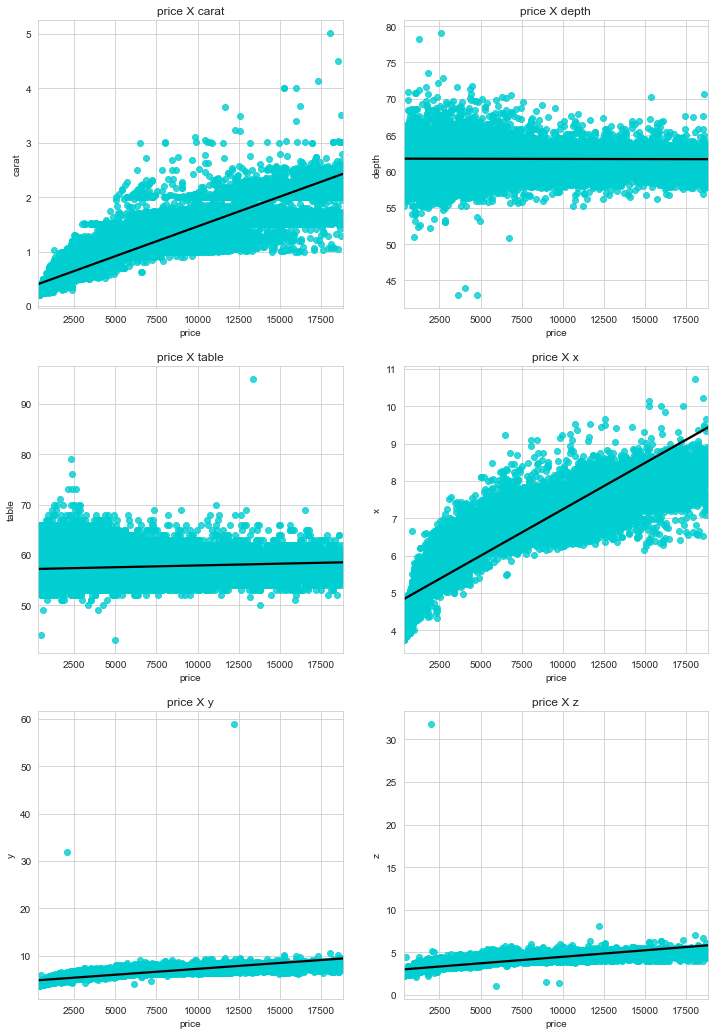

In [16]:
sns.set_style("whitegrid")
c = "darkturquoise"
plt.figure(figsize = (12, 18))
plt.subplot(3, 2, 1)
plt.title("price X carat")
sns.regplot(data = df, x = "price", y = "carat", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 2)
plt.title("price X depth")
sns.regplot(data = df, x = "price", y = "depth", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 3)
plt.title("price X table")
sns.regplot(data = df, x = "price", y = "table", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 4)
plt.title("price X x")
sns.regplot(data = df, x = "price", y = "x", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 5)
plt.title("price X y")
sns.regplot(data = df, x = "price", y = "y", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 6)
plt.title("price X z")
sns.regplot(data = df, x = "price", y = "z", color = c, line_kws = {"color" : "black"})
plt.show()

In [17]:
df_outliers = df.loc[df["y"] > 30].copy()
highlight_outliers(df_outliers, "y")

,carat,cut,color,clarity,depth,table,price,x,y,z
24012,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
49047,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12


In [18]:
df_outliers = df.loc[df["z"] > 30].copy()
highlight_outliers(df_outliers, "z")

,carat,cut,color,clarity,depth,table,price,x,y,z
48268,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80


In [19]:
df.loc[df["y"] > 30, "y"] = np.nan
df.loc[df["z"] > 30, "z"] = np.nan

In [20]:
fill_nan_values("y")
fill_nan_values("z")

carat: 2.0 / median y value: 8.01
carat: 0.51 / median y value: 5.14
carat: 0.51 / median z value: 3.17


,carat,cut,color,clarity,depth,table,price,x,y,z
48268,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,3.17


In [21]:
df_outliers = df.loc[(df["depth"] > 75) | (df["depth"] < 45)].copy()
highlight_outliers(df_outliers, "depth")
df_outliers = df.loc[(df["table"] > 90) | (df["depth"] < 45)].copy()
highlight_outliers(df_outliers, "table")
df_outliers = df.loc[df["z"] < 2].copy()
highlight_outliers(df_outliers, "z")

,carat,cut,color,clarity,depth,table,price,x,y,z
14602,1.07,Ideal,F,SI1,60.6,57.0,5909,6.62,6.67,1.07
20651,1.53,Ideal,I,SI1,61.9,54.0,8971,7.43,7.50,1.53
21609,1.41,Ideal,H,VS1,60.7,56.0,9752,7.31,7.22,1.41


In [22]:
df.loc[df["carat"] == df["z"], ["carat", "z"]]
df.loc[df["z"] < 2, "z"] = np.nan
fill_nan_values("z")

carat: 1.53 / median z value: 4.56
carat: 1.41 / median z value: 4.44
carat: 1.07 / median z value: 4.05


,carat,cut,color,clarity,depth,table,price,x,y,z
20651,1.53,Ideal,I,SI1,61.9,54.0,8971,7.43,7.50,4.56
21609,1.41,Ideal,H,VS1,60.7,56.0,9752,7.31,7.22,4.44
14602,1.07,Ideal,F,SI1,60.6,57.0,5909,6.62,6.67,4.05


In [23]:
cut_palette = ["darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
color_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
clarity_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure", "ghostwhite"]

df["cut"] = pd.Categorical(df["cut"], categories = ["Ideal", "Premium", "Very Good", "Good", "Fair"], ordered = True)
df["color"] = pd.Categorical(df["color"], categories = ["D", "E", "F", "G", "H", "I", "J"], ordered = True)
df["clarity"] = pd.Categorical(df["clarity"], categories = ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"], ordered = True)

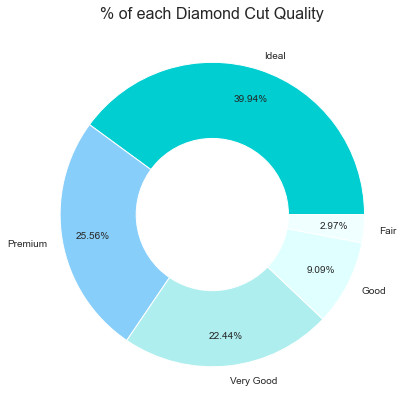

In [24]:
df_cut = df["cut"].value_counts()
plt.figure(figsize = (7,7))
plt.pie(data = df_cut, x = df_cut.values, labels = df_cut.index, autopct = "%.2f%%", pctdistance = 0.8, colors = cut_palette )
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Cut Quality", size = 16)
plt.show()

In [25]:
position = 0
for cut in df_cut:
    print("{0} quality cuts: {1}".format(df_cut.index[position], df_cut.values[position]))
    position += 1

Ideal quality cuts: 21488
Premium quality cuts: 13748
Very Good quality cuts: 12069
Good quality cuts: 4891
Fair quality cuts: 1598


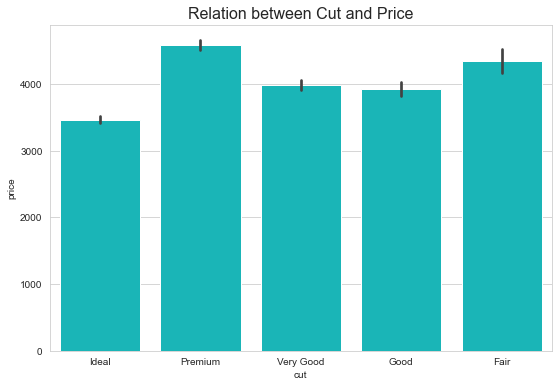

In [26]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "cut", y = "price", color = c)
plt.title("Relation between Cut and Price", size = 16)
plt.show()

In [27]:
get_corr("price")

price    1.000000
carat    0.921548
y        0.888703
x        0.887114
z        0.882251
table    0.126566
depth   -0.011048
dtype: float64

In [28]:
df.groupby(["cut"])["carat"].mean()

cut
Ideal        0.703472
Premium      0.891620
Very Good    0.806195
Good         0.847215
Fair         1.043736
Name: carat, dtype: float64

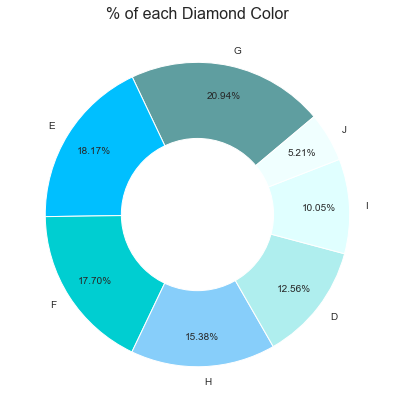

In [29]:
df_color = df["color"].value_counts()
plt.figure(figsize = (7,7))
plt.pie(data = df_color, x = df_color.values, labels = df_color.index, autopct = "%.2f%%", pctdistance = 0.8, startangle = 40, colors = color_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Color", size = 16)
plt.show()

In [30]:
position = 0
for color in df_color:
    print("{0} color diamonds: {1}".format(df_color.index[position], df_color.values[position]))
    position += 1

G color diamonds: 11262
E color diamonds: 9776
F color diamonds: 9520
H color diamonds: 8272
D color diamonds: 6755
I color diamonds: 5407
J color diamonds: 2802


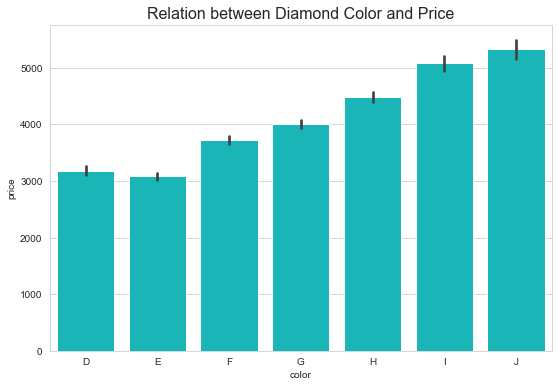

In [31]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "color", y = "price", color = c)
plt.title("Relation between Diamond Color and Price", size = 16)
plt.show()

In [32]:
df.groupby(["color"])["carat"].mean()

color
D    0.658315
E    0.657957
F    0.736664
G    0.771273
H    0.911029
I    1.025197
J    1.162841
Name: carat, dtype: float64

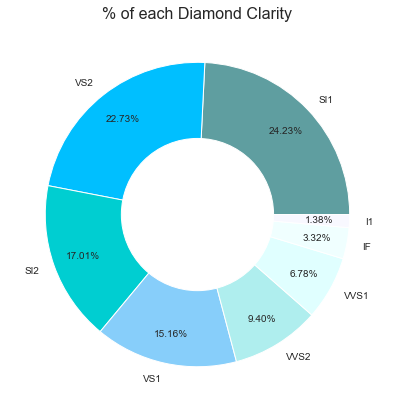

In [33]:
df_clarity = df["clarity"].value_counts()
plt.figure(figsize = (7,7))
plt.pie(data = df_clarity, x = df_clarity.values, labels = df_clarity.index, autopct = "%.2f%%", pctdistance = 0.8, colors = clarity_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Clarity", size = 16)
plt.show()

In [34]:
position = 0
for color in df_clarity:
    print("{0} clarity diamonds: {1}".format(df_clarity.index[position], df_clarity.values[position]))
    position += 1

SI1 clarity diamonds: 13032
VS2 clarity diamonds: 12229
SI2 clarity diamonds: 9150
VS1 clarity diamonds: 8156
VVS2 clarity diamonds: 5056
VVS1 clarity diamonds: 3647
IF clarity diamonds: 1784
I1 clarity diamonds: 740


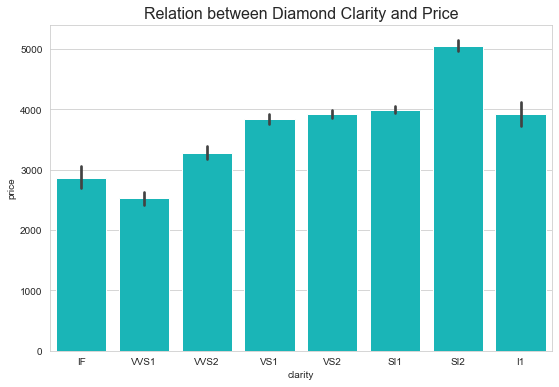

In [35]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "clarity", y = "price", color = c)
plt.title("Relation between Diamond Clarity and Price", size = 16)
plt.show()

In [36]:
df.groupby(["clarity"])["carat"].mean()

clarity
IF      0.505645
VVS1    0.503696
VVS2    0.596527
VS1     0.727436
VS2     0.764276
SI1     0.850407
SI2     1.076402
I1      1.283527
Name: carat, dtype: float64

In [37]:
X = df.drop(["price"], axis = 1).copy()
y = df["price"].copy()

In [38]:
X_dummies = X.copy()
X_dummies = pd.get_dummies(data = X_dummies, columns = ["clarity", "color", "cut"], prefix = ["clarity", "color", "cut"], drop_first = True).copy()
ss = StandardScaler()
X_dummies = ss.fit_transform(X_dummies)
X_encoder = X.copy()
X_encoder["cut"] = X_encoder["cut"].replace({"Ideal": 1, "Premium": 2, "Very Good": 3, "Good": 4, "Fair": 5}).copy()
X_encoder["color"] = X_encoder["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I": 2, "J": 1}).copy()
X_encoder["clarity"] = X_encoder["clarity"].replace({"IF" : 8, "VVS1" : 7, "VVS2" : 6, "VS1" : 5, "VS2" : 4, "SI1" : 3, "SI2" : 2, "I1" : 1}).copy()

In [39]:
kf = KFold(n_splits = 10, random_state = SEED, shuffle = True)
scoring = ["r2", "neg_mean_absolute_error", "neg_mean_squared_error"]

In [40]:
model_scores = {"train" : [],
                "test" : [],
                "mae" : [],
                "mse" : [],
                "rmse" : []}
def get_results(clf, features):
    scores = cross_validate(clf, features, y, cv = kf, scoring = scoring, return_train_score = True)
    train_score = scores["train_r2"].mean()
    model_scores["train"].append(train_score)
    test_score = scores["test_r2"].mean()
    model_scores["test"].append(test_score)
    mae = np.absolute(scores["test_neg_mean_absolute_error"]).mean()
    model_scores["mae"].append(mae)
    mse = np.absolute(scores["test_neg_mean_squared_error"]).mean()
    model_scores["mse"].append(mse)
    rmse = np.sqrt(mse)
    model_scores["rmse"].append(rmse)
    print("train score: {0:.4f}\nR2 score: {1:.4f}\nMAE: {2:.2f}\nMSE: {3:.2f}\nRMSE: {4:.2f}".format(train_score, test_score, mae, mse, rmse))

In [41]:
lr = LinearRegression()
get_results(lr, X_dummies)

train score: 0.9208
R2 score: 0.9206
MAE: 732.64
MSE: 1263206.91
RMSE: 1123.92


In [42]:
dtr = DecisionTreeRegressor(max_depth = 8, random_state = SEED)
get_results(dtr, X_encoder)

train score: 0.9722
R2 score: 0.9692
MAE: 388.15
MSE: 489904.63
RMSE: 699.93


In [43]:
rfr = RandomForestRegressor(max_depth = 8, n_estimators = 40, random_state = SEED)
get_results(rfr, X_encoder)

train score: 0.9776
R2 score: 0.9752
MAE: 343.96
MSE: 395114.38
RMSE: 628.58


In [44]:
xgbr = XGBRegressor(learning_rate = 0.1, n_estimators = 200, random_state = SEED)
get_results(xgbr, X_encoder)

train score: 0.9897
R2 score: 0.9831
MAE: 266.08
MSE: 268514.71
RMSE: 518.18


In [45]:
print("train score\n")
print("Linear Regression: {0:.4f}\nDecision Tree: {1:.4f}\nRandom Forest: {2:.4f}\nXGBoost: {3:.4f}".format(model_scores["train"][0],model_scores["train"][1], model_scores["train"][2], model_scores["train"][3]))
print("\nR2 score\n")
print("Linear Regression: {0:.4f}\nDecision Tree: {1:.4f}\nRandom Forest: {2:.4f}\nXGBoost: {3:.4f}".format(model_scores["test"][0],model_scores["test"][1], model_scores["test"][2], model_scores["test"][3]))
print("\nMAE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["mae"][0],model_scores["mae"][1], model_scores["mae"][2], model_scores["mae"][3]))
print("\nMSE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["mse"][0],model_scores["mse"][1], model_scores["mse"][2], model_scores["mse"][3]))
print("\nRMSE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["rmse"][0],model_scores["rmse"][1], model_scores["rmse"][2], model_scores["rmse"][3]))

train score

Linear Regression: 0.9208
Decision Tree: 0.9722
Random Forest: 0.9776
XGBoost: 0.9897

R2 score

Linear Regression: 0.9206
Decision Tree: 0.9692
Random Forest: 0.9752
XGBoost: 0.9831

MAE

Linear Regression: 732.64
Decision Tree: 388.15
Random Forest: 343.96
XGBoost: 266.08

MSE

Linear Regression: 1263206.91
Decision Tree: 489904.63
Random Forest: 395114.38
XGBoost: 268514.71

RMSE

Linear Regression: 1123.92
Decision Tree: 699.93
Random Forest: 628.58
XGBoost: 518.18
